In order to import the dataset from kagglehub, we need to install the kagglhub as kagglehub doesn't come installed within the python library.

In [ ]:
!pip install kagglehub

To import the dataset, we create a API key which is downloaded as a json file in the local device. Everytime, the dataset is imported, the json file is selected.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nischalgauchan","key":"e05db14e6c75f1b4c72a2da56ab0d62e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



Since the dataset is imported and not downloaded, therefore everytime the session ends the file associated with the dataset are vanished from the content folder. Thus, the content is mounted in the drive to persist the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ayuraj/asl-dataset")

print("Path to dataset files:", path)

100%|██████████| 56.9M/56.9M [00:00<00:00, 107MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ayuraj/asl-dataset/versions/1


In [ ]:
!cp -r /root/.cache/kagglehub/datasets/ayuraj/asl-dataset/versions/1 /content/asl_dataset

The following libraries and modules are necessary for machine learning. The os module helps managing directories for the dataset, numpy for creating 1D array, matplot library to plot images for graphical representation. The sklearn machine learing is especially used for image recognition.

In [ ]:
import os, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf
from tensorflow import keras

layers = keras.layers
models = keras.models
Adam = keras.optimizers.Adam

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


Dataset Splitting

The process involves splitting the dataset into training, validation and testing set where training set always take the bigger chunk of dataset and smaller portion of dataset are feed for validation and testing set.

To prevent data bias, the dataset is splitted evenly with shuffle. It will ensure that for each training, validation and testing set, the dataset is evenly distributed.

In [ ]:
dataset_dir = "/content/asl_dataset/asl_dataset"
output_dir = "/content/drive/MyDrive/asl_dataset_split"

for split in ["train", "val", "test"]:
    split_path = os.path.join(output_dir, split)
    os.makedirs(split_path, exist_ok=True)

    for cls in os.listdir(dataset_dir):
        cls_path = os.path.join(dataset_dir, cls)
        if os.path.isdir(cls_path):
            os.makedirs(os.path.join(split_path, cls), exist_ok=True)

train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

for cls in os.listdir(dataset_dir):
    cls_path = os.path.join(dataset_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
    random.shuffle(files)

    train_end = int(train_ratio * len(files))
    val_end = train_end + int(val_ratio * len(files))

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    for f in train_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(output_dir, "train", cls))
    for f in val_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(output_dir, "val", cls))
    for f in test_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(output_dir, "test", cls))

The step involves resizing the image as 224*224 pixel value which is a common input for CNN. The batch size is the amount of images feed into the model per time.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(output_dir, "train"),
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(output_dir, "val"),
    image_size=(224, 224),
    batch_size=32
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(output_dir, "test"),
    image_size=(224, 224),
    batch_size=32
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 2511 files belonging to 37 classes.
Found 1410 files belonging to 37 classes.
Found 1512 files belonging to 37 classes.


Usually for an 8-bit images, it's pixel value extends from 0 to 255. Normalization basically shrinks the value from 0 to 255 to 0 to 1. We do it simply by dividing each value by 1./255.

In [ ]:
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

This is the core concept of CNN. The very first layer is known as a Convolutional Layer. Images as inputs are subjected to 32 filters (each of 2*2 size) and extracts the important features from the images which are known as featuremap. In the next stage, the same process repeats but this time the process extracts the most prominent features. This is achieved by reducing the dimensionality of the images. The output, feature map, but with the core features. The last layer is called Fully Connected Layer, where actual decison is made based on extracted feature map. SoftMax converts outputs into probabilities.

In [ ]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Training Model

Epochs refer to the amount of time a model is trained on a dataset. Setting the appropriate number for epochs could help reduce overfitting.

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 455s 6s/step - accuracy: 0.3226 - loss: 2.5851 - val_accuracy: 0.9175 - val_loss: 0.3075
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 382s 5s/step - accuracy: 0.8201 - loss: 0.6055 - val_accuracy: 0.9681 - val_loss: 0.1083
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.8928 - loss: 0.3420 - val_accuracy: 0.9812 - val_loss: 0.0487
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.9208 - loss: 0.2313 - val_accuracy: 0.9910 - val_loss: 0.0307
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 380s 5s/step - accuracy: 0.9400 - loss: 0.1754 - val_accuracy: 0.9935 - val_loss: 0.0175
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step - accuracy: 0.9553 - loss: 0.1256 - val_accuracy: 0.9975 - val_loss: 0.0138
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.9614 - loss: 0.1226 - val_accuracy: 0.9967 - val_loss: 0.0126
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.9736 - loss: 0.0797 - val_accuracy: 0.9975 - v

Final Evaluation

It provides the accuracy for the model on test dataset. The test accuracy inidcates how well the model performed and test loss measures the error rate.

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

33/33 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9926 - loss: 0.0167
Test accuracy: 0.9952380657196045
Test loss: 0.0126773901283741


After the model has been trained, its time to test how accurately it can identify the images. It iterates through the test dataset to generate the prediction and the index representing the largest predicted value is known as argmax. The index corresponds to the class model thinks the image belongs to.

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━

In [ ]:
print("Unique labels in y_true:", np.unique(y_true))
print("Number of class_names:", len(class_names))

Unique labels in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]
Number of class_names: 37


Performance Metrics

Performance metrics refers to the model ability to perform well in the dataset. Recall refers to the accuracy of system to detect the amount of positive instances which were predicted to be positive instance. Precision contradicts precision as it is the accuracy of the system to detect the number of positive instances which were actually present. F1 score is the harmonic mean of Recall and Precision.


Four components of confusion matrix refers to false positive, false negative, true positive and true negative. False means inaccurate and True means accurate indication.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        41
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        33
           6       0.00      0.00      0.00        36
           7       0.00      0.00      0.00        39
           8       0.02      0.04      0.03        47
           9       0.00      0.00      0.00        40
           a       0.00      0.00      0.00        37
           b       0.00      0.00      0.00        42
           c       0.00      0.00      0.00        47
           d       0.00      0.00      0.00        43
           e       0.00      0.00      0.00        41
           f       0.00      0.00      0.00        52
           g       0.00      0.00      0.00        42
           h       0.00    

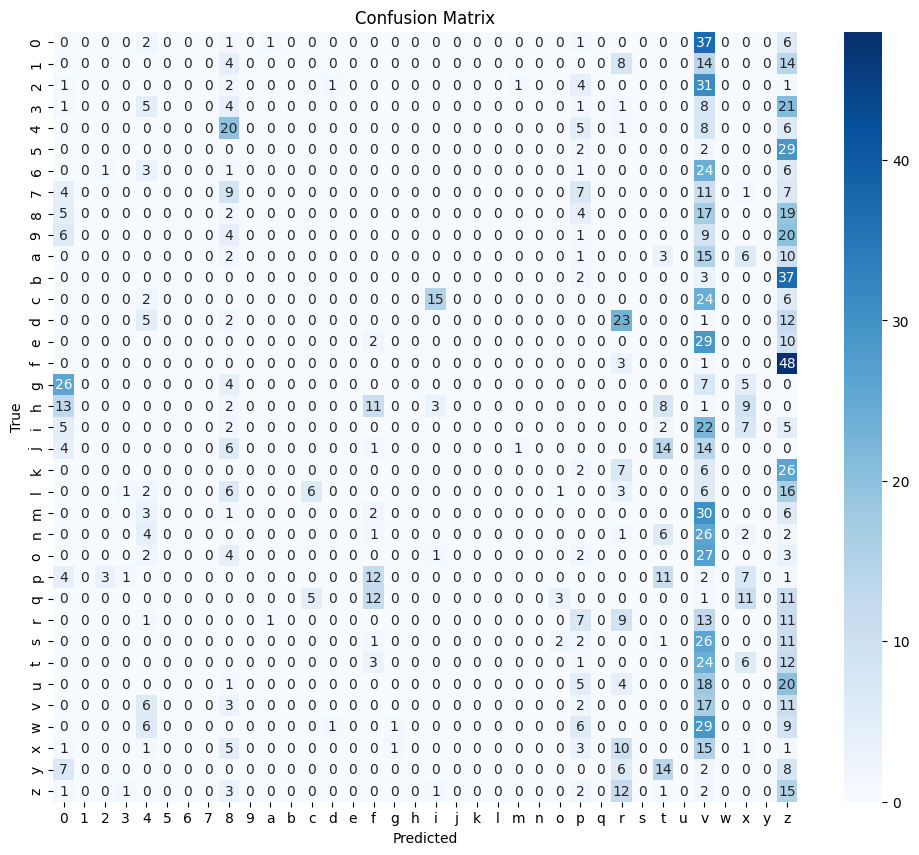

In [ ]:
labels = sorted(np.unique(y_true))
filtered_names = [class_names[i] for i in labels]


print(classification_report(y_true, y_pred,
                            labels=labels,
                            target_names=filtered_names))

cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=filtered_names,
            yticklabels=filtered_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()